In [24]:
%matplotlib inline 

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams.update({'font.size': 18})

In [25]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

from keras import backend as K
import numpy as np

In [26]:
def power_function(k, sigmasignal = 17.5, amplitude = 1e6 ):
    function =  np.exp(-float(k)*float(k)/(2.0*sigmasignal*sigmasignal))/(np.sqrt(2.0*np.pi)*(sigmasignal))
    if function <= 0.0:
        return 1e-19
    else:
        return amplitude*function

def make_map(size, sigmasignal = None):
    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            power_map[i, j] = 1e-15
        else:
            if sigmasignal is None:
                power_map[i, j] = power_function(k_map[i, j])
            else:
                power_map[i, j] = power_function(k_map[i, j], sigmasignal)
            
    power_sample = np.random.normal(loc=0.0, scale=np.sqrt(0.5 * np.reshape(power_map, -1))) +\
               1j *  np.random.normal(loc=0.0, scale=np.sqrt(0.5 *  np.reshape(power_map, -1)))
    power_sample = np.reshape(power_sample, (size, size))
    
        # enforce hermitian and iFFT to get map
    map_fourier = np.zeros((size,size), dtype = complex)
    for (i, j,), value in np.ndenumerate(map_fourier):
        n = i - int(size/2)
        m = j - int(size/2)

        if n == 0 and m ==0:
            map_fourier[i,j] = 1e-15

        elif i ==0 or j == 0:
            map_fourier[i,j] = np.sqrt(2)*power_sample[i,j] 

        else:
            map_fourier[i,j] = power_sample[i,j] #
            map_fourier[size - i,size - j] = np.conj(power_sample[i,j])

    return  np.fft.ifft2(np.fft.fftshift(map_fourier)), power_map

(<matplotlib.image.AxesImage at 0xb31278cf8>,
 <matplotlib.colorbar.Colorbar at 0xb3019bb00>)

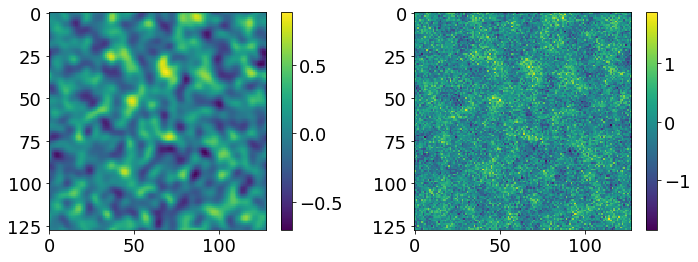

In [35]:
map_size = 128
stdev = 0.4
sigma_power = 6.

example, power_map = make_map(map_size, sigma_power)

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.imshow(example.real), plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(example.real + np.random.normal(0,stdev, (map_size,map_size,))), plt.colorbar()



(<matplotlib.image.AxesImage at 0xb301bf5f8>,
 <matplotlib.colorbar.Colorbar at 0xb2bc58c50>)

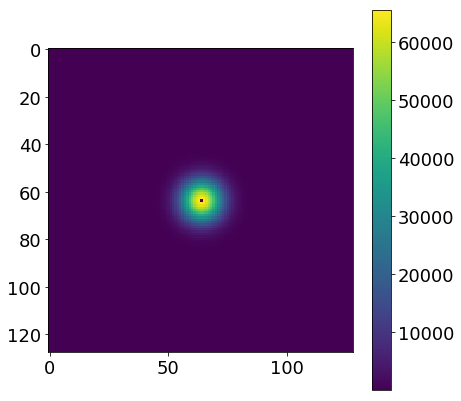

In [36]:
plt.subplot(1,2,1)
plt.imshow(power_map), plt.colorbar()

In [10]:
# counts = np.load('camelus_sv_counts.npy')[0].T

# counts64 =  counts.reshape(64, counts.shape[0]/64, 64, counts.shape[1]/64).sum(axis=1).sum(axis=2)
# mask64 = np.where(counts64>0.0, 1.0, 0.0)

In [38]:
training_size = 40000
testing_size = 500

train_array_clean = np.empty((training_size,map_size,map_size,1), dtype = np.float32)
print(train_array_clean.shape)
train_array_noisy = np.empty((training_size,map_size,map_size,1), dtype = np.float32)
test_array_clean = np.empty((testing_size,map_size,map_size,1), dtype = np.float32)
test_array_noisy = np.empty((testing_size,map_size,map_size,1), dtype = np.float32)

for i in range(training_size):
    image, foo = make_map(map_size, sigma_power)
    image = np.float32(np.real(image))
    image += -np.mean(image)
    train_array_clean[i,:,:,0] = np.real(image)
    train_array_noisy[i,:,:,0] = np.real(image) + np.float32(np.random.normal(0,stdev, (map_size,map_size,)))
#     train_array_noisy[i,:,:,0] = train_array_noisy[i,:,:,0] * np.float32(mask64)

    
for i in range(testing_size):
    image, foo = make_map(map_size, sigma_power)
    image = np.float32(np.real(image))
    image += -np.mean(image)
    test_array_clean[i,:,:,0] = np.real(image)
    test_array_noisy[i,:,:,0] = np.real(image) + np.float32(np.random.normal(0,stdev, (map_size,map_size,)))
#     test_array_noisy[i,:,:,0] = test_array_noisy[i,:,:,0] * np.float32(mask64)


(40000, 128, 128, 1)


KeyboardInterrupt: 

In [12]:
train_array_clean = train_array_clean/(15.0 * stdev) + 0.5
train_array_noisy = train_array_noisy/(15.0 * stdev) + 0.5
test_array_clean  = test_array_clean/(15.0 * stdev)  + 0.5
test_array_noisy  = test_array_noisy/(15.0 * stdev)  + 0.5

train_array_clean = np.where(train_array_clean >= 1, 0.99999999, train_array_clean)
train_array_clean = np.where(train_array_clean <= 0, 1e-8, train_array_clean)

train_array_noisy = np.where(train_array_noisy >= 1, 0.99999999, train_array_noisy)
train_array_noisy = np.where(train_array_noisy <= 0, 1e-8, train_array_noisy)

test_array_clean = np.where(test_array_clean >= 1, 0.99999999, test_array_clean)
test_array_clean = np.where(test_array_clean <= 0, 1e-8, test_array_clean)

test_array_noisy = np.where(test_array_noisy >= 1, 0.99999999, test_array_noisy)
test_array_noisy = np.where(test_array_noisy <= 0, 1e-8, test_array_noisy)


In [13]:
rescaled_power = power_map*15.0 * stdev*15.0 * stdev

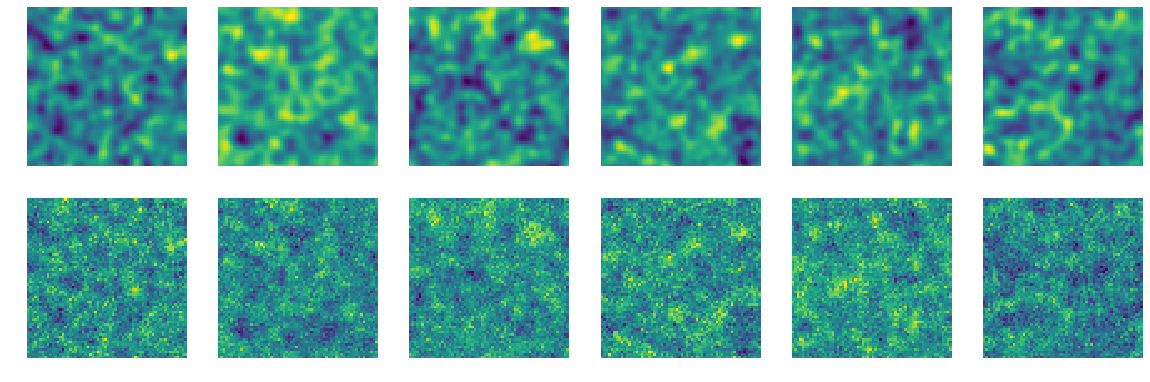

In [14]:
n = 6  # how many images displayed

plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(train_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(train_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')

    plt.axis('off')
plt.show()

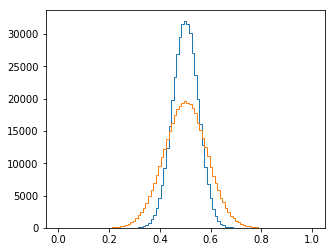

In [15]:
_  = plt.figure(figsize = (5,4))
_ = plt.hist(np.reshape(test_array_clean, -1), np.linspace(0,1,100), histtype = 'step')
_ = plt.hist(np.reshape(test_array_noisy, -1), np.linspace(0,1,100), histtype = 'step')

In [37]:
input_img = Input(shape=(map_size, map_size, 1))  

filters = 32

x = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta',loss='mse')
# autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 32)        0         
__________

In [54]:
autoencoder.fit(train_array_noisy, train_array_clean,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(test_array_noisy, test_array_clean),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 4000 samples, validate on 100 samples
Epoch 1/100
4000/4000 [==============================] - 56s 14ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/100
4000/4000 [==============================] - 53s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
4000/4000 [==============================] - 54s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
4000/4000 [==============================] - 54s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/100
4000/4000 [==============================] - 54s 14ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
4000/4000 [==============================] - 55s 14ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/100
4000/4000 [==============================] - 55s 14ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
4000/4000 [==============================] - 55s 14ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/100
4000/4000 [==============================] - 55s 14ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10

KeyboardInterrupt: 

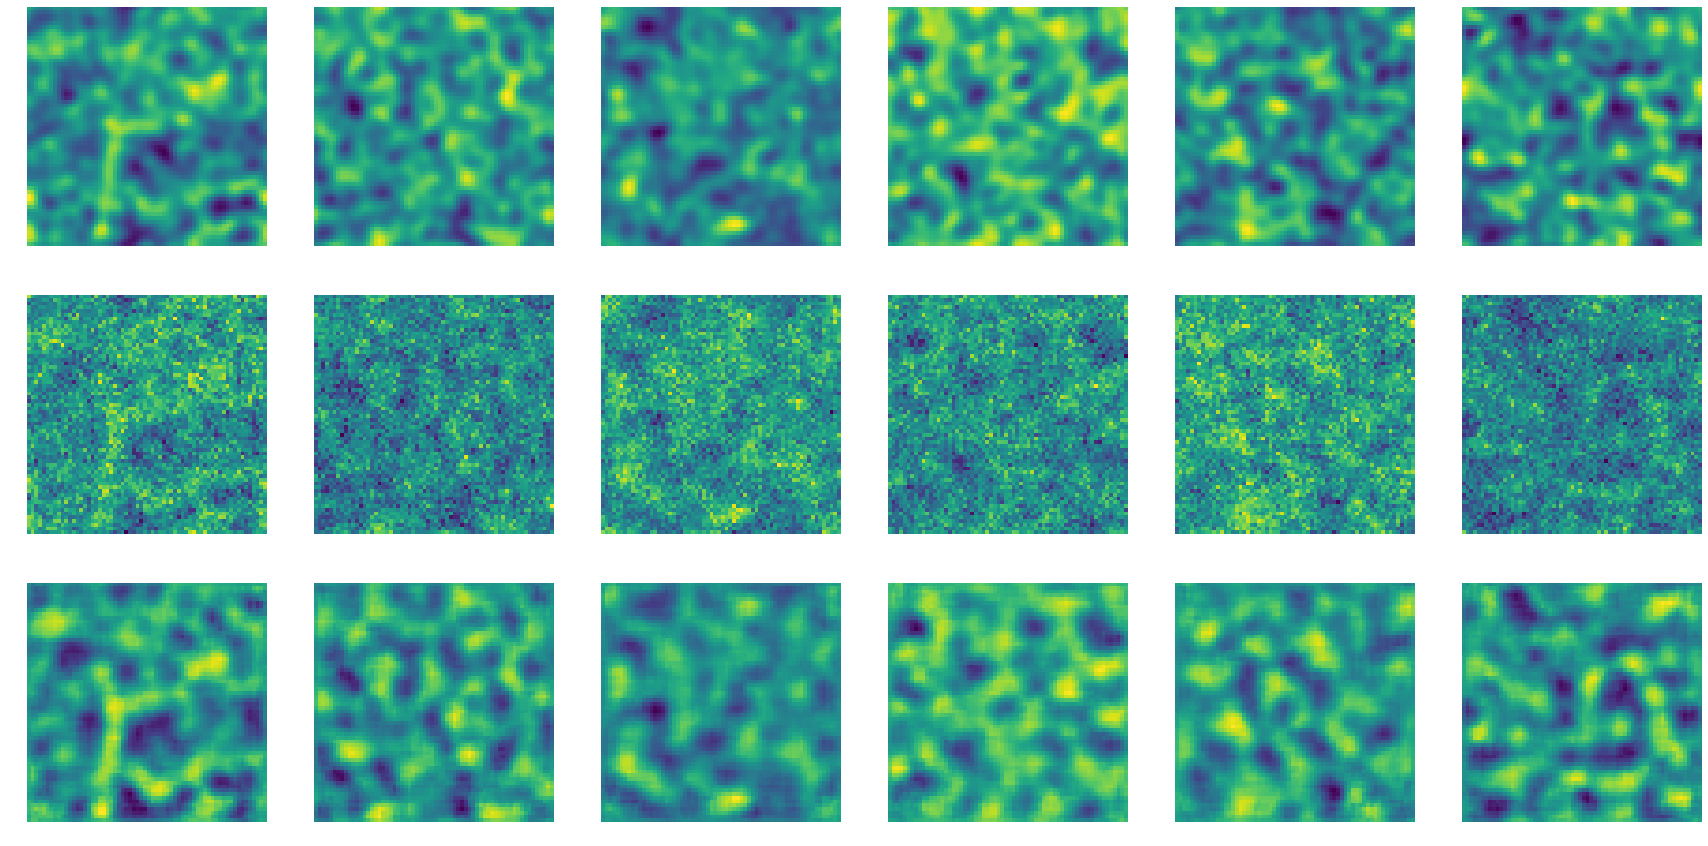

In [55]:
test_output = autoencoder.predict(test_array_noisy)

n = 6  # how many images displayed

plt.figure(figsize=(30, 15))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(test_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(test_output[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')

    plt.axis('off')
plt.show()

In [56]:
Sft_diagonal = np.reshape(power_map, -1)
N_constant_diagonal = np.ones(Sft_diagonal.shape) * stdev * stdev
Nft_constant_diagonal = N_constant_diagonal * 64 * 64.


W = Sft_diagonal / (Sft_diagonal + Nft_constant_diagonal)

In [57]:
fourier_data = np.fft.fftshift(np.fft.fft2(test_array_noisy[0,:,:,0]-0.5))

In [58]:
wiener_map_fourier = np.reshape( W* np.reshape(fourier_data, -1), (64,64))
wiener_map = np.fft.ifft2(np.fft.fftshift(wiener_map_fourier))

(<matplotlib.image.AxesImage at 0xb28531eb8>,
 Text(0.5, 1.0, 'wiener'),
 <matplotlib.colorbar.Colorbar at 0xb2961cd30>)

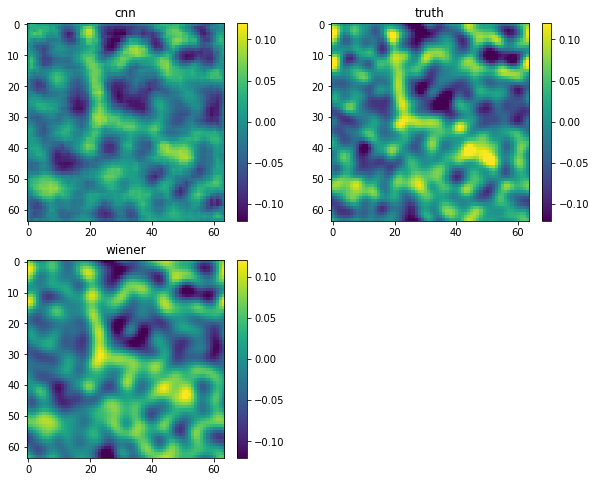

In [64]:
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.imshow(test_output[0,:,:,0].real - 0.5, clim = (-0.12,0.12)), plt.title('cnn'), plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(test_array_clean[0,:,:,0].real - 0.5, clim = (-0.12,0.12)), plt.title('truth'), plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(wiener_map.real, clim = (-0.12,0.12)), plt.title('wiener'), plt.colorbar()

In [60]:
autoencoder.save('encoder_301018.h5')

In [15]:
read_encoder = load_model('encoder_301018.h5')

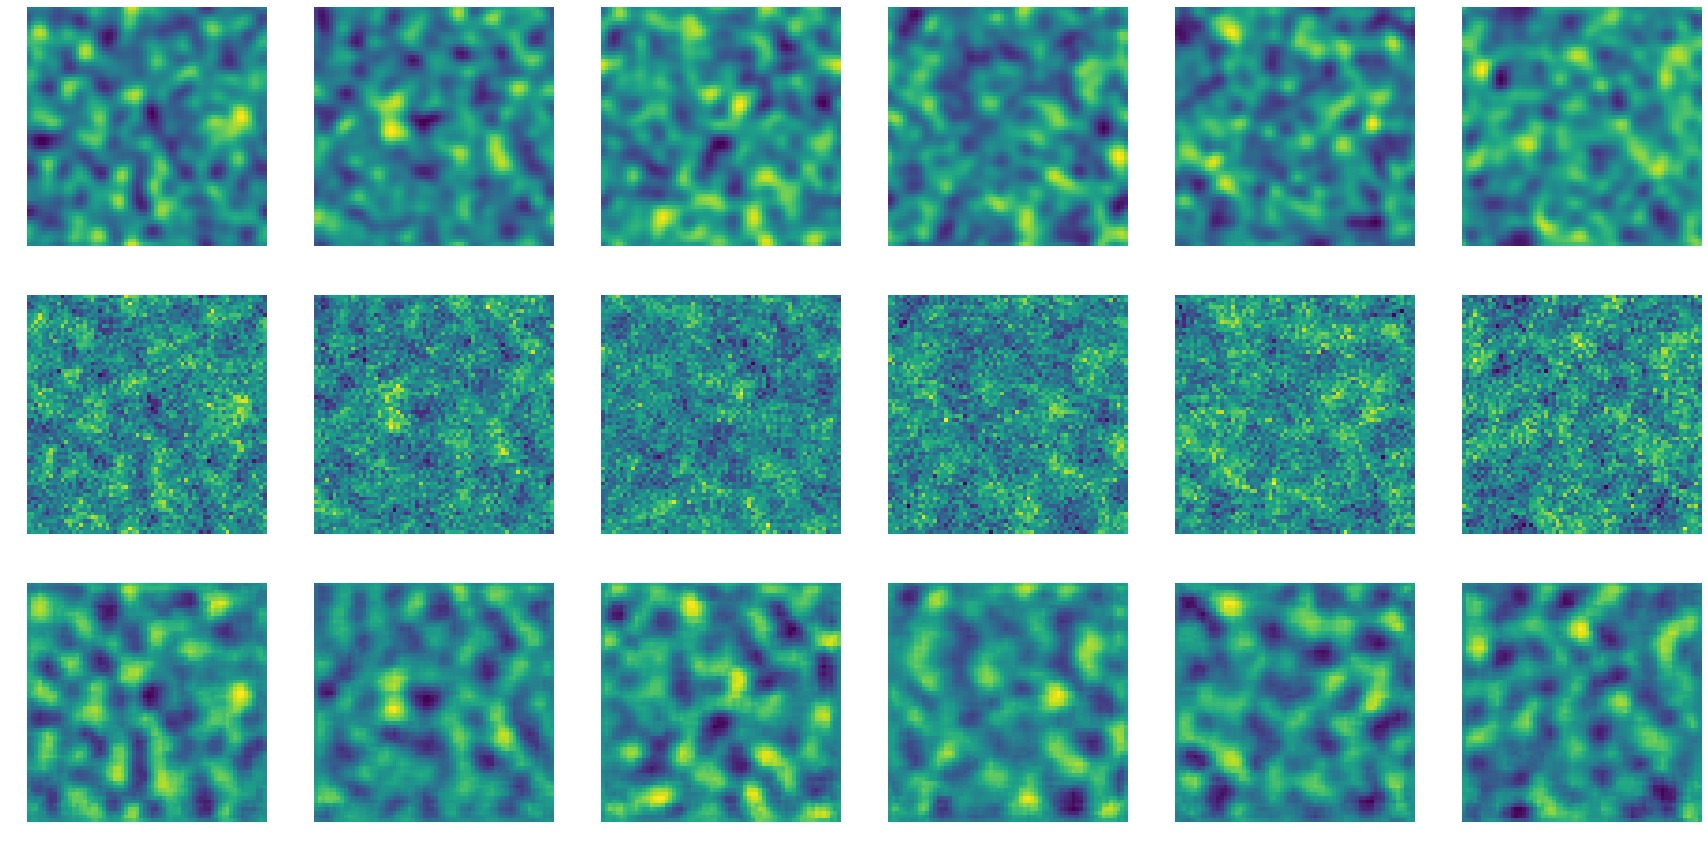

In [16]:
test_output_loaded = read_encoder.predict(test_array_noisy)

n = 6  # how many images displayed

plt.figure(figsize=(30, 15))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1)
    plt.imshow(test_array_clean[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_array_noisy[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')
    
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(test_output_loaded[i,:,:,0], origin = 'lower')#, clim= (0.,1.))
    plt.axis('off')

    plt.axis('off')
plt.show()

In [22]:
from keras.utils import plot_model
plot_model(read_encoder, show_shapes=True, show_layer_names=False, to_file='model.png')

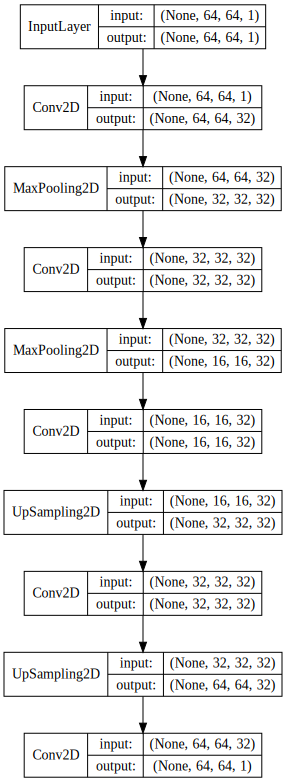

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(read_encoder, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))